---
## Single Cell Proteomics Meta-Analysis
### Author: Gerard Font
**Date: January 2025**<br>
**MBDS - Master Biomedical Data Science**

Meta-analysis, is a statistical technique that combines and analyzes data from multiple independent studies, has become increasingly important in the field of single-cell proteomics. By integrating data from different experiments, meta-analysis allows for the identification of robust and reproducible findings, overcoming the limitations of individual studies and providing a more comprehensive view of the biological landscape.

The objectives of this thesis are as follows:
1. Review and summarize the existing literature on single-cell proteomics and meta-analysis.
2. Collect and curate relevant single-cell proteomic datasets from public repositories.
3. Develop a comprehensive data analysis pipeline for meta-analysis of single-cell proteomic data.
4. Apply the developed pipeline to integrate and analyze the collected datasets.
5. Identify differentially expressed proteins, cellular subpopulations, and potential biomarkers.
6. Validate the findings through comparison with independent datasets and experimental validation.
7. Interpret the results and provide biological insights into the studied biological systems.

Through this master thesis, I hope to provide a comprehensive overview of the data analysis techniques employed in single-cell proteomics meta-analysis and demonstrate their utility in uncovering novel biological insights.

---

### Cell types

* **M0** - Undifferentiated macrophages or monocytes
* **M1** - Classically activated macrophages (LPS or IFN-γ)
* **M2** - Alternatively activated macrophages (IL-4 or IL-13) 
<br>

---
### Import Libraries


In [1]:
# Import pandas
import pandas as pd

from matplotlib import pyplot as plt

# Venn diagram
from matplotlib_venn import venn3








import numpy as np


# Core scverse libraries
import scanpy as sc
import anndata as ad

# Gerard's libraries
from src.uniprot_client import UniprotClient

# Data retrieval
import pooch

# import seaborn
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap

from scipy.stats import fisher_exact

from IPython.display import Image, display
from src.uniprot_client import UniprotClient
from src.stringdb_client import StringDBClient

import gseapy as gp

/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


___
### Config

In [2]:
TRANSLATE_PROTEIN_ID = False

---
### Data Sources

./data/processed/2016_Iwata_ncomms12849/**SI_THP_RAW_proteomics_data_ss.xlsx**<br>
*Iwata, H., Goettsch, C., Sharma, A., Ricchiuto, P., Goh, W. W. bin, Halu, A., Yamada, I., Yoshida, H., Hara, T., Wei, M., Inoue, N., Fukuda, D., Mojcher, A., Mattson, P. C., Barabási, A. L., Boothby, M., Aikawa, E., Singh, S. A., & Aikawa, M. (2016). PARP9 and PARP14 cross-regulate macrophage activation via STAT1 ADP-ribosylation. Nature Communications 2016 7:1, 7(1), 1–19. https://doi.org/10.1038/ncomms12849*
<br><br>
./data/processed/2022_Pengfei LI_35557041/**PD_Globalproteomics_2024.xlsx**<br>
*Li, P., Ma, C., Li, J., You, S., Dang, L., Wu, J., Hao, Z., Li, J., Zhi, Y., Chen, L., & Sun, S. (2022). Proteomic characterization of four subtypes of M2 macrophages derived from human THP-1 cells. Journal of Zhejiang University. Science. B, 23(5), 407–422. https://doi.org/10.1631/jzus.B2100930*
<br><br>
./data/processed/2021_Pengfei LI_34267761/**THP1_global_M0_M1_M2_proteins.xlsx**<br>
*Li, P., Hao, Z., Wu, J., Ma, C., Xu, Y., Li, J., Lan, R., Zhu, B., Ren, P., Fan, D., & Sun, S. (2021). Comparative Proteomic Analysis of Polarized Human THP-1 and Mouse RAW264.7 Macrophages. Frontiers in Immunology, 12, 700009. https://doi.org/10.3389/FIMMU.2021.700009/FULL*

---

### Dataset formats
Each of the files/experiments prepared a specific format that require to be adapted to make it comparable with other datasetes. These are the different formats used in the meta-analysis:


**SI_THP_RAW_proteomics_data_ss.xlsx**
* **Accession:** This is a unique identifier assigned to a protein, often from databases like UniProt or RefSeq.
* **Description:** A brief description of the protein's function or characteristics.
* **Score:** A numerical value representing the confidence level of the protein identification. Higher scores indicate more reliable identifications.
* **Coverage:** The percentage of the protein's amino acid sequence that has been covered by identified peptides.
* **#Proteins:** The number of proteins associated with the identified peptides.
* **#Unique Peptides:** The number of distinct peptide sequences identified.
* **#Peptides:** The total number of peptides identified, including duplicates.
* **#PSMs:** The number of Peptide Spectrum Matches, which represent the number of times a peptide sequence has been identified in the mass spectra.
* **126/126 Count:** Counts at moment 0hr
* **127/126 Count:** Counts at moment 8hr
* **128/126 Count:** Counts at moment 12hr
* **129/126 Count:** Counts at moment 24hr   <--   We take this one as a reference
* **130/126 Count:** Counts at moment 48hr
* **131/126 Count:** Counts at moment 72hr

Additional information: https://www.biotech.iastate.edu/wp_biotech/wp-content/uploads/2023/07/ProteomeDiscovererInstructions.pdf
<br><br>

**PD_Globalprotomics_2024.xlsx**

* **Protein FDR Confidence: Combined**: Reflects the level of confidence in the identification of each protein
* **Master**: A unique identifier assigned to each protein group.
* **Accession**: A database accession number (e.g., UniProt) for the protein.
* **Description**: A textual description of the protein's function and characteristics.
* **Sum PEP Score**: The sum of peptide-spectrum match (PSM) scores, indicating overall confidence in protein identification.
* **# Peptides**: The number of peptides identified for the protein.
* **# PSMs**: The total number of PSMs for the protein.
* **# Protein Unique Peptides**: The number of peptides uniquely assigned to this protein.
* **# Unique Peptides**: The total number of unique peptides identified.
* **# AAs**: The number of amino acids in the protein sequence.
* **MW [kDa]**: The molecular weight of the protein in kilodaltons.
* **Score Sequest HT: Sequest HT**: The score assigned by the Sequest HT search engine for the protein identification.
* **# Razor Peptides**: The number of peptides uniquely assigned to this protein group, helping to distinguish it from other similar proteins.
* *Quantitative Proteomics Data*
    * **Abundance Ratio**: These columns represent the relative abundance of a protein in different experimental conditions (e.g., M0, M1, M2a, M2b, M2c, M2d). The ratios are calculated by dividing the abundance of a protein in one condition by the abundance in another condition.
    * **Abundances (Grouped)**: These columns represent the absolute or normalized abundance of a protein in each experimental group.
    * **Abundances (Normalized)**: These columns represent the normalized abundance of a protein in each individual sample (F1-F18). Normalization is a process to account for experimental variability and ensure accurate comparison of protein abundance across samples.
* **Modifications**: This column indicates any post-translational modifications (PTMs) identified on the protein, such as phosphorylation or acetylation.

<br><br>
**THP1_global_M0_M1_M2_proteins.xlsx**
* **Checked:** Indicates whether the protein identification was manually checked.
* **Protein FDR Confidence:** False Discovery Rate (FDR) confidence level for the protein identification.
* **Combined:** Indicates whether the protein identification is based on a combination of different search engines or data sources.
* **Master Unique Sequence ID:** A unique identifier assigned to the master protein.
* **Protein Group IDs:** Identifiers for protein groups, which can include isoforms or related proteins.
* **Accession:** Accession number from a protein database (e.g., UniProt).
* **Description:** Brief description of the protein function.
* **FASTA Title Lines:** The FASTA header line corresponding to the protein sequence.
* **Exp. q-value: Combined:** The q-value (FDR-adjusted p-value) for the protein identification.
* **Sum PEP Score:** The summed peptide expectation score for the protein.
* **# Decoy Protein: Combined:** The number of decoy proteins identified in the analysis.
* **Coverage [%]:** The percentage of the protein sequence covered by identified peptides.
* **# Peptides:** The number of peptides identified for the protein.
* **# PSMs:** The number of peptide spectrum matches (PSMs) identified.
* **# Protein Unique Peptides:** The number of peptides unique to the protein.
* **# Unique Peptides:** The number of unique peptide sequences identified.
* **# AAs:** The number of amino acids in the protein sequence.
* **MW [kDa]:** The molecular weight of the protein in kilodaltons.
* **calc. pI:** The calculated isoelectric point of the protein.
* **Score Sequest HT:** The score assigned by the Sequest HT search engine.
* **Coverage [%] (by Search Engine): Sequest HT:** The coverage by Sequest HT.
* **# PSMs (by Search Engine): Sequest HT:** The number of PSMs identified by Sequest HT.
* **# Peptides (by Search Engine): Sequest HT:** The number of peptides identified by Sequest HT.
* **# Razor Peptides:** The number of razor peptides, which are uniquely assigned to a single protein group.
* Quantitative Data:
    * **Abundance Ratio: (M1) / (M0):** The ratio of protein abundance between two conditions (M1 and M0).
    * **Abundance Ratio (log2): (M1) / (M0):** The log2-transformed abundance ratio.
    * **Abundance Ratio P-Value:** The p-value for the difference in abundance between the two conditions.
    * **Abundance Ratio Adj. P-Value:** The adjusted p-value for the abundance ratio.
    * **Abundance Ratio Variability [%]:** The variability in the abundance ratio.
    * **Abundance Ratio Weight:** The weight assigned to the abundance ratio.
    * **Abundances (Grouped): M0, M1, M2:** The grouped abundance values for each condition.
    * **Abundances (Grouped) CV [%]:** The coefficient of variation for the grouped abundance values.
    * **Abundances (Grouped) Count:** The number of replicates for each condition.
    * **Abundances (Scaled):** The scaled abundance values for each sample.
    * **Abundances (Normalized):** The normalized abundance values for each sample.
    * **Abundance:** The absolute abundance value for each sample.
    * **Abundances Count:** The number of replicates for each sample.
* Sample Information:
    * **Found in File:** The file name where the protein was identified.
    * **Found in Sample:** The sample name where the protein was identified.
    * **Found in Sample Group:** The sample group where the protein was identified.
    * **# Protein Groups:** The number of protein groups identified in the sample.
    * **Modifications:** Any identified post-translational modifications on the protein.

In [20]:
# Paths to each of the data sources
path_2016_iwata = "./data/processed/2016_Iwata_ncomms12849/SI_THP_RAW_proteomics_data_ss.xlsx"
path_2022_pengfei = "./data/processed/2022_Pengfei LI_35557041/PD_Globalproteomics_2024.xlsx"
path_2021_pengfei = "./data/processed/2021_Pengfei LI_34267761/THP1_global_M0_M1_M2_proteins.xlsx"


---
### Load the Data

In [4]:
# EXPERIMENT 1
# Load the data from different sheets
df_2016_iwata_M0 = pd.read_excel(path_2016_iwata, sheet_name="THP_M0", index_col=0) # Index = Accession
df_2016_iwata_M1 = pd.read_excel(path_2016_iwata, sheet_name="THP_M1", index_col=0) 
df_2016_iwata_M2 = pd.read_excel(path_2016_iwata, sheet_name="THP_M2", index_col=0) 

# Merge the three datasets
df_2016_iwata = pd.concat([df_2016_iwata_M0, df_2016_iwata_M1, df_2016_iwata_M2], keys=["M0", "M1", "M2"], names=["Type"])
df_2016_iwata = df_2016_iwata.reset_index(level=0).rename(columns={"level_0": "Type"})

# EXPERIMENT 2
df_2022_pengfei = pd.read_excel(path_2022_pengfei, sheet_name="Proteins", index_col=2) # Index = Accession

# EXPERIMENT 3
df_2021_pengfei = pd.read_excel(path_2021_pengfei, sheet_name="Proteins", index_col=5) # Index = Accession

/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [24]:
print("Total number of proteins found in each dataset (include proteins found in M0, M1 and M2):")
print("2016 Iwata et al.:", len(df_2016_iwata.index.unique()))
print("2022 Pengfei et al.:", len(df_2022_pengfei.index.unique()))
print("2021 Pengfei et al.:", len(df_2021_pengfei.index.unique()))


Total number of proteins found in each dataset (include proteins found in M0, M1 and M2):
2016 Iwata et al.: 9048
2022 Pengfei et al.: 6616
2021 Pengfei et al.: 7349


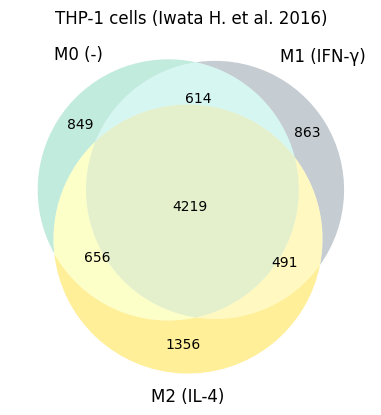

In [5]:
# Venn diagram
exp1_proteinsM0 = set(df_2016_iwata_M0.index)
exp1_proteinsM1 = set(df_2016_iwata_M1.index)
exp1_proteinsM2 = set(df_2016_iwata_M2.index)

venn3([exp1_proteinsM0, exp1_proteinsM1, exp1_proteinsM2], set_labels = ('M0 (-)', 'M1 (IFN-γ)', 'M2 (IL-4)'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.title("THP-1 cells (Iwata H. et al. 2016)")
plt.show()

### TODO: Check how they were stimulated and remove INF-y and IL-4 if needed


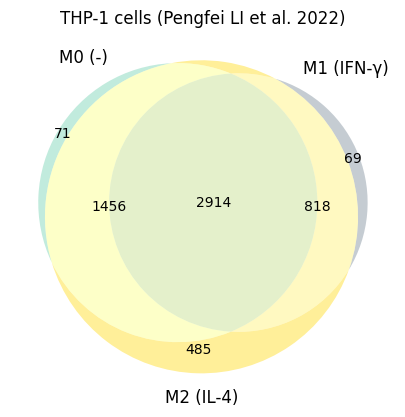

In [6]:
# Venn diagram for df_2022_shisheng (M0, M1 and M2 as a whole)
MIN_ABUNDANCE = 75

exp2_proteinsM0 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > MIN_ABUNDANCE].index)
exp2_proteinsM1 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > MIN_ABUNDANCE].index)
exp2_proteinsM2a = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2a"] > MIN_ABUNDANCE].index)
exp2_proteinsM2b = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2b"] > MIN_ABUNDANCE].index)
exp2_proteinsM2c = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2c"] > MIN_ABUNDANCE].index)
exp2_proteinsM2d = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2d"] > MIN_ABUNDANCE].index)

exp2_proteinsM2 = exp2_proteinsM2a.union(exp2_proteinsM2b).union(exp2_proteinsM2c).union(exp2_proteinsM2d)

# Venn diagram
plt.title("THP-1 cells (Pengfei LI et al. 2022)")
venn3([exp2_proteinsM0, exp2_proteinsM1, exp2_proteinsM2], set_labels = ('M0 (-)', 'M1 (IFN-γ)', 'M2 (IL-4)'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))

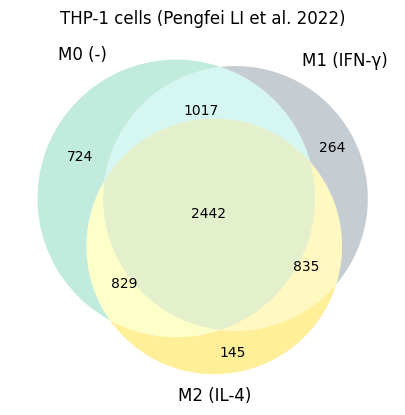

In [7]:

exp3_proteinsM0 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > MIN_ABUNDANCE].index)
exp3_proteinsM1 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > MIN_ABUNDANCE].index)
exp3_proteinsM2 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > MIN_ABUNDANCE].index)

# Venn diagram
plt.title("THP-1 cells (Pengfei LI et al. 2022)")
venn3([exp3_proteinsM0, exp3_proteinsM1, exp3_proteinsM2], set_labels = ('M0 (-)', 'M1 (IFN-γ)', 'M2 (IL-4)'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))

### Proteins found in all the datasets for each of the states

**M0**


In [15]:
exp1_m0_only = exp1_proteinsM0 - exp2_proteinsM0 - exp3_proteinsM0
exp2_m0_only = exp2_proteinsM0 - exp1_proteinsM0 - exp3_proteinsM0
exp3_m0_only = exp3_proteinsM0 - exp1_proteinsM0 - exp2_proteinsM0

common_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0)

print("Common proteins in M0: ", len(common_proteins))
print(list(common_proteins)[:10])

Common proteins in M0:  1815
['Q92747', 'Q6DKI1', 'P20618', 'O75934', 'P19623', 'P51665', 'Q9BRG1', 'O95478', 'Q9ULR0', 'P18621']


**M1**

In [18]:
exp1_m1_only = exp1_proteinsM1 - exp1_proteinsM0 - exp1_proteinsM2
exp2_m1_only = exp2_proteinsM1 - exp2_proteinsM0 - exp2_proteinsM2
exp3_m1_only = exp3_proteinsM1 - exp3_proteinsM0 - exp3_proteinsM2

# Common proteins
common_proteins = exp1_m1_only.intersection(exp2_m1_only).intersection(exp3_m1_only)
print("Common proteins in M1: ", len(common_proteins))
print(common_proteins)




Common proteins in M1:  7
{'Q9NZQ7', 'A6NK06', 'Q99572', 'Q5R3K3', 'P14902', 'P02778', 'Q96PP8'}


**M2**

In [19]:
exp1_m2_only = exp1_proteinsM2 - exp1_proteinsM0 - exp1_proteinsM1
exp2_m2_only = exp2_proteinsM2 - exp2_proteinsM0 - exp2_proteinsM1
exp3_m2_only = exp3_proteinsM2 - exp3_proteinsM0 - exp3_proteinsM1

# Common proteins
common_proteins = exp1_m2_only.intersection(exp2_m2_only).intersection(exp3_m2_only)
print("Common proteins in M2: ", len(common_proteins))
print(common_proteins)


Common proteins in M2:  1
{'O94788'}


### Proteins with high abudance ratio in M1 vs M0



In [ ]:
# Get the proteins with high abundance in M1 vs M0
exp1_m1_high = 


In [10]:
# Take the proteins with higher variance between M1 and M2
# Calculate the variance for each protein at point 131/126
#dataM1["VarianceVsM2"] = dataM1["131/126"] - dataM2["131/126"]
dataM1["VarianceVsM2"] = np.log10(dataM1["129/126"]) - np.log10(dataM2["129/126"])
dataM1["VarianceVsM2"] = dataM1["VarianceVsM2"]

# Sort the proteins by variance
dataM1 = dataM1.sort_values(by="VarianceVsM2", ascending=False)

# Take the top 10 proteins
top_proteins = dataM1.head(12)

# Print the top proteins
print("Top proteins with higher variance between M1 and M2")
print(top_proteins.index)
print(top_proteins["VarianceVsM2"])




NameError: name 'dataM1' is not defined

In [ ]:
# Load count table
data_src = "./data/processed/2022_Shisheng SUN_35557041/PD_Globalproteomics_2022.xlsx"

# Load the data (index is the second column)
df = pd.read_excel(data_src, sheet_name="Proteins", index_col=2)

# Print the columns
print(df.columns)


### Matrix format

* **Protein FDR Confidence: Combined**: Reflects the level of confidence in the identification of each protein
* **Master**: A unique identifier assigned to each protein group.
* **Accession**: A database accession number (e.g., UniProt) for the protein.
* **Description**: A textual description of the protein's function and characteristics.
* **Sum PEP Score**: The sum of peptide-spectrum match (PSM) scores, indicating overall confidence in protein identification.
* **# Peptides**: The number of peptides identified for the protein.
* **# PSMs**: The total number of PSMs for the protein.
* **# Protein Unique Peptides**: The number of peptides uniquely assigned to this protein.
* **# Unique Peptides**: The total number of unique peptides identified.
* **# AAs**: The number of amino acids in the protein sequence.
* **MW [kDa]**: The molecular weight of the protein in kilodaltons.
* **Score Sequest HT: Sequest HT**: The score assigned by the Sequest HT search engine for the protein identification.
* **# Razor Peptides**: The number of peptides uniquely assigned to this protein group, helping to distinguish it from other similar proteins.

Quantitative Proteomics Data

* **Abundance Ratio**: These columns represent the relative abundance of a protein in different experimental conditions (e.g., M0, M1, M2a, M2b, M2c, M2d). The ratios are calculated by dividing the abundance of a protein in one condition by the abundance in another condition.
* **Abundances (Grouped)**: These columns represent the absolute or normalized abundance of a protein in each experimental group.
* **Abundances (Normalized)**: These columns represent the normalized abundance of a protein in each individual sample (F1-F18). Normalization is a process to account for experimental variability and ensure accurate comparison of protein abundance across samples.

Additional Information

* **Modifications**: This column indicates any post-translational modifications (PTMs) identified on the protein, such as phosphorylation or acetylation.

---


**Filter the low quality data**

Criteria:
* Peptides at least 2
* Confidence level = High

In [ ]:
# Print number of initial rows
print("Initial number of rows:", len(df))

# Drop rows with "Protein FDR Confidence: Combined" = "Low"
df = df[df["Protein FDR Confidence: Combined"] != "Low"]

# Drop rows with # Peptides < 2
df = df[df["# Peptides"] >= 2]

# Print number of rows after filtering
print("Number of rows after filtering:", len(df))

---

### Exploratory Data Analysis

* Density plot of Log2FC
* Log5 PSMs / Log2FC


In [ ]:
# Compute the average of Abundance ratios for M2
groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df["Abundance Ratio: M2 / M1"] = df[groupM2].mean(axis=1)

# Compute the Log2FC of the abundance ratios
df["Log2FC"] = np.log2(df["Abundance Ratio: M2 / M1"])




In [ ]:
LOG2FC_CUTOFF = 2
PSM_CUTOFF = 50

plt.figure(figsize=(10, 8))

# Add lines for Log2FC cutoffs (adjust as needed for significant fold changes)
plt.axvline(x=LOG2FC_CUTOFF, color='grey', linestyle='--')
plt.axvline(x=-LOG2FC_CUTOFF, color='grey', linestyle='--')

plt.axhline(y=PSM_CUTOFF, color='grey', linestyle='--')

plt.xlabel("Log2 Fold Change")
plt.ylabel("Number of PSMs")
plt.title("Protein Abundance Based on Log2 Fold Change and PSMs")
plt.yscale('log')  # Optional: Log scale for PSMs if counts vary widely

# Number of proteins with significant fold changes and PSMs
n_sig = df[(df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)].shape[0]
plt.text(3.5, 450, f'{n_sig}', fontsize=14)

# Number of proteins with significant fold changes and PSMs
n_sig = df[(df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)].shape[0]
plt.text(-5, 450, f'{n_sig}', fontsize=14)


# Plot significant proteins
sig = df[(df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)]
sns.scatterplot(
    data=sig,
    x='Log2FC',
    y='# PSMs',
    color='red',
    size='# PSMs',
    alpha=0.7
)

sig = df[(df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)]
sns.scatterplot(
    data=sig,
    x='Log2FC',
    y='# PSMs',
    color='red',
    size='# PSMs',
    alpha=0.7
)

# Plot all other proteins in grey
sns.scatterplot(
    data=df[~((df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)) & ~((df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF))],
    x='Log2FC',
    y='# PSMs',
    color='grey',
    size='# PSMs',
    alpha=0.7
)

plt.legend().remove()
plt.show()


---
### Analyze the proteins found only in one of the two groups (M1 and M2)

In [ ]:
# Define experimental groups
group1 = ['Abundances (Grouped): M1']
group2 = ['Abundances (Grouped): M2a', 'Abundances (Grouped): M2b', 'Abundances (Grouped): M2c', 'Abundances (Grouped): M2d']

# Compute the mean of group 2
df['Abundances (Grouped): M2'] = df[group2].mean(axis=1)

Next step is to plot those proteins that are more abundant in M1 vs M2

In [ ]:
# Take the 20 more abundant proteins in M1 & M2
top_proteins_m1 = df.sort_values(by="Abundances (Grouped): M1", ascending=False).head(20)
top_proteins_m2 = df.sort_values(by="Abundances (Grouped): M2", ascending=False).head(20)

# Venn diagram to see the overlap between the two considering the index value
venn2([set(top_proteins_m1.index), set(top_proteins_m2.index)], set_labels=('M1', 'M2'))
plt.title('Top 20 proteins in M1 and M2')
plt.show()


The result are groups of 20 proteins that do not overlap, which means that the top 20 more abundant proteins are only present in one of the two groups

In [ ]:
# Now we need to analyze that are present in both groups and have a significant change in abundance.
# We first need to remove the rows that are not present in both groups
df_both = df.dropna(subset=group1 + group2).copy()

# Proteins with the highest abundance ratio in M2 vs M1
groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df_both["Abundance Ratio: M2 / M1"] = df_both[groupM2].mean(axis=1)

In [ ]:
# Print the Accession of the top 20 proteins with the highest abundance ratio
topUP_proteins_ratio = df_both.sort_values(by="Abundance Ratio: M2 / M1", ascending=False).head(20)
topDOWN_proteins_ratio = df_both.sort_values(by="Abundance Ratio: M2 / M1", ascending=True).head(20)

# Print the Abundance Ratio: M2 / M1 of the top 20 proteins
print(topUP_proteins_ratio["Abundance Ratio: M2 / M1"])
print(topDOWN_proteins_ratio["Abundance Ratio: M2 / M1"])

Now I want to comput the log2 fold change and p-values to analyze those up/down regulated proteins (M1 vs M2)

In [ ]:

# Convert columns to numeric, handling potential errors
for col in group1 + group2:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Calculate log2 fold change and p-values
df['log2FC'] = df[group1].mean(axis=1) - df[group2].mean(axis=1)
print(df['log2FC'].describe())

# Drop missing values for log2FC
df = df.dropna(subset=['log2FC'])

# Check missing values for log2FC
print(df['log2FC'].isnull().sum())

df['p_value'] = df.apply(lambda row: ttest_ind(row[group1], row[group2]).pvalue, axis=1)

# Adjust p-values for multiple testing (e.g., Bonferroni correction)
df['adj_p_value'] = multipletests(df['p_value'], alpha=0.05, method='bonferroni')[1]

# Filter for significant DEPs
sig_deps = df[df['adj_p_value'] < 0.05]

# Visualize results (e.g., volcano plot)
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=sig_deps, x='log2FC', y='-log10(adj_p_value)', hue='adj_p_value < 0.05')
plt.title('Volcano Plot')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(Adjusted p-value)')
plt.show()

# Further analysis and visualization
# - Cluster analysis (e.g., hierarchical clustering, PCA)
# - Functional enrichment analysis (e.g., Gene Ontology, KEGG pathway analysis)
# - Protein-protein interaction network analysis

In [ ]:
# Heatmap of the top 100 proteins found in columns of group1 + group2. Use the group1 and group2 variables to get the values for each group.
top_proteinsM1 = df.sort_values(by="Abundances (Grouped): M1", ascending=False).head(100)
top_proteinsM2 = df.sort_values(by="Abundances (Grouped): M2", ascending=False).head(100)

# Merge the two dataframes
top_proteins_df = pd.merge(top_proteinsM1, top_proteinsM2, on="Accession")

print(top_proteins_df)
# Keep only the columns with the abundances and the accession
top_proteins_df = top_proteins_df[["Accession", "Abundances (Grouped): M1_x", "Abundances (grouped): M2_y"]]

# Normalize the data
top_proteins_df = top_proteins_df.div(top_proteins_df.sum(axis=1), axis=0)

print(top_proteins_df.head())

# Plot the heatmap
sns.heatmap(top_proteins_df, cmap="viridis")
plt.title('Top 100 proteins in M1 and M2')
plt.show()







In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM1.index)
    print(gene_names)

    # Add the gene names to the data as another column
    dataM1['Gene'] = gene_names
    


---

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot violin plot for M1
sns.violinplot(data=dataM1.select_dtypes(include=[np.number]), ax=axs[0])
axs[0].set_title("VM1")
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Values")

# Plot violin plot for M2
sns.violinplot(data=dataM2.select_dtypes(include=[np.number]), ax=axs[1])
axs[1].set_title("M2")
axs[1].set_xlabel("Variables")
axs[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

In [ ]:
# Describe the data
print("M1")
print(dataM1.describe())

print("M2")
print(dataM2.describe())

In [ ]:

# M1
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M1')
sns.boxplot(y=dataM1["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM1["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM1["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM1["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM1["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM1["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

# M2
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M2')
sns.boxplot(y=dataM2["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM2["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM2["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM2["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM2["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM2["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

In [ ]:
PEPTIDE_THRESHOLD = 2

# Print the number of proteins with less than PEPTIDE_THRESHOLD peptides
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M1: {dataM1[dataM1['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M2: {dataM2[dataM2['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")

# Filter out data with less than 2 peptides
dataM1 = dataM1[dataM1["# Peptides"] >= PEPTIDE_THRESHOLD]
dataM2 = dataM2[dataM2["# Peptides"] >= PEPTIDE_THRESHOLD]

In [ ]:
# Bottom limit for SCORE in percentage
SCORE_PCT_THRESHOLD = 25

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1
sns.histplot(dataM1['Score'], bins=50, log_scale=True, ax=axs[0])
m1_score_threshold = np.percentile(dataM1['Score'], SCORE_PCT_THRESHOLD)
axs[0].set_title("Distribution of scores (M1)")
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_score_threshold, color='red')

# Plot dataM2
sns.histplot(dataM2['Score'], bins=50, log_scale=True, ax=axs[1])
m2_score_threshold = np.percentile(dataM2['Score'], SCORE_PCT_THRESHOLD)
axs[1].set_title("Distribution of scores (M2)")
axs[1].set_xlabel("Score")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_score_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['Score'] >= m1_score_threshold].shape[0]
print(f"%Proteins (Score >= {m1_score_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['Score'] >= m2_score_threshold].shape[0]
print(f"%Proteins (Score >= {m2_score_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")


In [ ]:
# Bottom limit for # PSMs in percentage
PSM_PCT_THRESHOLD = 10

# Plot the distribution of scores and # PSMs for both dataM1 and dataM2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1 # PSMs
sns.histplot(dataM1['# PSMs'], bins=50, log_scale=True, ax=axs[0])
m1_psm_threshold = np.percentile(dataM1['# PSMs'], PSM_PCT_THRESHOLD)
axs[0].set_title("Distribution of # PSMs (M1)")
axs[0].set_xlabel("# PSMs")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_psm_threshold, color='red')

# Plot dataM2 # PSMs
sns.histplot(dataM2['# PSMs'], bins=50, log_scale=True, ax=axs[1])
m2_psm_threshold = np.percentile(dataM2['# PSMs'], PSM_PCT_THRESHOLD)
axs[1].set_title("Distribution of # PSMs (M2)")
axs[1].set_xlabel("# PSMs")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_psm_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold for both dataM1 and dataM2
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['# PSMs'] >= m1_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m1_psm_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['# PSMs'] >= m2_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m2_psm_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")




In [ ]:

# Example dataset (replace with your data)
data = dataM1.drop(columns=['Description'])

# Compute pairwise correlations
correlations = data.corr().abs()  # Absolute correlation to avoid negative values

# Create a custom gradient from red to green
cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"])

# Function to get color based on correlation value
def get_color(value, cmap):
    norm_value = (value - correlations.min().min()) / (correlations.max().max() - correlations.min().min())
    return cmap(norm_value)

# do the same, but now using grey color for the diagonal
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10, 'alpha':0.1, 'edgecolor': None}, diag_kws={'color':'grey'})  # 's' controls dot size

# Loop through the axes to color each scatter plot
for i, j in zip(*np.triu_indices_from(correlations, 1)):
    ax = g.axes[i, j]
    corr_value = correlations.iloc[i, j]
    color = get_color(corr_value, cmap)
    
    # Apply the color gradient to all scatter plot
    ax.collections[0].set_facecolor(color)
    ax = g.axes[j, i]
    ax.collections[0].set_facecolor(color)


plt.show()




In [ ]:


# Define pairs of features to plot
features_to_plot = [
    ('# PSMs', '# Peptides'),
    ('# PSMs', '# Unique Peptides'),
    ('# Peptides', '# Unique Peptides'),
    ('Coverage', 'Score'),
    ('Score', '# PSMs'), 
    ('# Proteins', '# Unique Peptides')
]

# Set grid dimensions (adjust as needed)
rows, cols = 2, 2  # Create a 2x2 grid
rows, cols = features_to_plot.__len__() // 2, 2

# Configure plot size and style outside the loop (efficiency)
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Set figure size and create axes grid
point_size = 20
alpha = 0.2
marker = 'o'
color = 'blue'
grid_params = {'linestyle': '--', 'linewidth': 0.5, 'color': 'gray', 'which': 'both', 'alpha': 0.5}



# Loop through features and create plots
for i in range(rows):
    for j in range(cols):
        x_feature, y_feature = features_to_plot[i * cols + j]  # Access feature pair

        # Create the scatter plot on the current axis
        axes[i, j].scatter(dataM1[x_feature], dataM1[y_feature], s=point_size, alpha=alpha, marker=marker, c=color)

        # Set axis labels and title
        axes[i, j].set_xlabel(x_feature, fontsize=10)
        axes[i, j].set_ylabel(y_feature, fontsize=10)
        axes[i, j].set_title(f'{x_feature} vs. {y_feature}', fontsize=12)

        # Add grid lines
        axes[i, j].grid(**grid_params)

# Adjust spacing and display the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

### Consider only those proteins with **Score** above the Threshold 

In [ ]:
dataM1 = dataM1[dataM1['Score'] >= m1_score_threshold]
dataM2 = dataM2[dataM2['Score'] >= m2_score_threshold]

### List the 100 most present proteins in both M1 and M2  *(do not work for identyfing the cell type)*
As "present" I consider those that appear more frequent in the spectra (based on PSMs)

In [ ]:
TOP_NUMBER = 100

# Take the top proteins based on the PSMs value (sorted in descending order)
topM1 = dataM1.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)
topM2 = dataM2.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)


In [ ]:
plt.figure(figsize=(9, 9))

# Filter the proteins present in both topM1 and topM2
common_top_proteins = topM1.index.intersection(topM2.index)
print(f"Number of common proteins: {len(common_top_proteins)}")

# Create a mask to filter the common proteins
mask_common = dataM1.index.isin(common_top_proteins)

# plot
plt.scatter(topM1.loc[common_top_proteins]['Score'], topM2.loc[common_top_proteins]['Score'])
plt.xlabel('Score (M1)')
plt.ylabel('Score (M2)')
plt.title('Score (M1) vs Score (M2) for common proteins')
# Add the names of the proteins in small font
for protein in common_top_proteins:
    # add a separation between the dot and the text
    separation = 0.1
    plt.text(topM1.loc[protein]['Score']+separation, topM2.loc[protein]['Score'], protein, fontsize=6)

# Diagonal line
max_value = max(topM1['Score'].max(), topM2['Score'].max())
plt.plot([0, max_value], [0, max_value], color='red')

plt.show()




In [ ]:
# Print a table with the first 10 proteins of common_top_proteins. The table must contain the Accession, Description, ScoreM1, ScoreM2, #PSMs M1, #PSMs M2, #Peptides M1, #Peptides M2, #Unique Peptides M1, #Unique Peptides M2, Coverage M1, Coverage M2
print("Table with the first 10 proteins of common_top_proteins")

# Create a table with the first 10 proteins of common_top_proteins
table = pd.DataFrame(index=common_top_proteins[:10])
table['Description'] = dataM1.loc[common_top_proteins[:10]]['Description']
table['Score M1'] = dataM1.loc[common_top_proteins[:10]]['Score']
table['Score M2'] = dataM2.loc[common_top_proteins[:10]]['Score']
table['# PSMs M1'] = dataM1.loc[common_top_proteins[:10]]['# PSMs']
table['# PSMs M2'] = dataM2.loc[common_top_proteins[:10]]['# PSMs']
table['# Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Peptides']
table['# Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Peptides']
table['# Unique Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Unique Peptides']
table['# Unique Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Unique Peptides']
table['Coverage M1'] = dataM1.loc[common_top_proteins[:10]]['Coverage']
table['Coverage M2'] = dataM2.loc[common_top_proteins[:10]]['Coverage']

print(table)



### Differential Expression Analysis

In [ ]:
# Get the number of proteins in each dataset
n_proteins_M1 = len(dataM1)
n_proteins_M2 = len(dataM2)

# Get the number of proteins in common
common_proteins = dataM1.index.intersection(dataM2.index)
n_common_proteins = len(common_proteins)

# Create the Venn diagram plot
c = venn2(subsets=(n_proteins_M1 - n_common_proteins, n_proteins_M2 - n_common_proteins, n_common_proteins),
    set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)

# Add a title to the plot
plt.title('Proteins found in M1 and M2')

# Display the plot
plt.show()




In [ ]:

# Check the number of NaN values in dataM1 and dataM2
print("Number of NaN values in dataM1")
print(dataM1.isnull().sum())
print("Number of NaN values in dataM2")
print(dataM2.isnull().sum())

# Create a copy by mergin dataM1 and dataM2 keeping the proteins present in only one of the datasets
merged_data = pd.merge(dataM1, dataM2, how='outer', on='Accession', suffixes=('_M1', '_M2'))
merged_data_original = merged_data.copy()
print(merged_data.isnull().sum())

merged_data['Description_M2'] = merged_data['Description_M2'].fillna('N/A')
merged_data['Description_M1'] = merged_data['Description_M1'].fillna('N/A')

# Replace missing values (NaN) with a very small value
merged_data.fillna(1e-1000, inplace=True)
print(merged_data.isnull().sum())

# Log fold change with the adjusted value
merged_data['Log2FC'] = np.log2(merged_data['# PSMs_M2'] + 1) - np.log2(merged_data['# PSMs_M1'] + 1)



As we can observe, there is no missing value in the original dataset.

In [ ]:
print(f"Number of 'N/A' in Description_M1: {merged_data[merged_data['Description_M1'] == 'N/A'].shape[0]}")
print(f"Number of 'N/A' in Description_M2: {merged_data[merged_data['Description_M2'] == 'N/A'].shape[0]}")

print(f"Number of proteins that are present in both datasets: {merged_data_original[merged_data_original['Description_M1'].notnull() & merged_data_original['Description_M2'].notnull()].shape[0]}")


In [ ]:
# Add a 'class' column to the merged_data. 
merged_data['class'] = "Both"
merged_data.loc[(merged_data['Description_M1'] != 'N/A') & (merged_data['Description_M2'] == 'N/A'), 'class'] = "M1"
merged_data.loc[(merged_data['Description_M1'] == 'N/A') & (merged_data['Description_M2'] != 'N/A'), 'class'] = "M2"
print(merged_data['class'].value_counts())           



In [ ]:
# Distribution of the log fold change for the class "Booth"
plt.figure(figsize=(10, 6))
sns.histplot(merged_data[merged_data['class'] == 'Both']['Log2FC'], bins=50, kde=True)
plt.title("Log2FC distribution for proteins present in both conditions")
plt.xlabel("Log2FC")
plt.ylabel("Frequency")
plt.show()   



Positive values in the 'Log2FC' column represent proteins that are more abundant in condition M2 compared to M1.<br>
Negative Log2FC values indicate proteins that are more abundant in condition M1 compared to M2.<br><br>
*Note that it was computed using #PSMs.*

In [ ]:
# Top 10 proteins with the highest log fold change
top10 = merged_data.sort_values(by='Log2FC', ascending=False).head(10)
print(top10[['Description_M1', 'Description_M2', 'Log2FC']])


In [ ]:
# describe merged_data
print(merged_data.describe())

In [ ]:
# Create the PCA object
pca = PCA(n_components=2)

# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler
scaler.fit(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Transform the data
X = scaler.transform(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Fit the PCA
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Create a dataframe with the PCA values
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Add the class column
pca_df['class'] = merged_data['class'].values

# Plot the PCA
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class')
plt.title('PCA of the merged data')
plt.show()


In [ ]:
# Create the UMAP object
umap_obj = umap.UMAP()

# Fit the UMAP
umap_obj.fit(X)

# Transform the data
X_umap = umap_obj.transform(X)

# Create a dataframe with the UMAP values
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Add the class column
umap_df['class'] = merged_data['class'].values

# Plot the UMAP
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='class')
plt.title('UMAP of the merged data')
plt.show()


In [ ]:
# Initialize a list to store p-values
p_values = []

# Loop through each protein to calculate the p-value using Fisher's exact test
for index, row in merged_data.iterrows():
    # Create a 2x2 contingency table based on presence/absence in M1 and M2
    # Assumes 1 for present, 0 for absent
    if row['class'] == 'M1' or row['class'] == 'M2':
        present_m1 = 1 if row['class'] == 'M1' else 0
        present_m2 = 1 if row['class'] == 'M2' else 0

        # Contingency table format: [[present in M1, absent in M1], [present in M2, absent in M2]]
        contingency_table = [[present_m1, 1 - present_m1], [present_m2, 1 - present_m2]]
        
        # Perform Fisher's Exact Test
        _, p_val = fisher_exact(contingency_table)
        p_values.append(p_val)
    else:
        # If the protein is present in both or absent in both, assign a default p-value (e.g., 1)
        p_values.append(1.0)

# Add p-values to the dataframe
merged_data['p_value_class'] = p_values

# print unique p-values
print(f"Unique p-values (class): {len(set(p_values))}")



As **all p-values are 1**, it means that there is no significant difference between the two groups for any protein.
This make sense considering the chart with the PSM's (M1) vs PSM's (M2) 

---
# DEA
Identify proteins that are significantly upregulated or downregulated between different conditions (M1 vs M2).

In [ ]:
data = merged_data.copy()
# drop p_value_class
data = data.drop(columns=['p_value_class'])
print(data.describe())

In [ ]:
# Create a "data" dataframe with the columns 'Accession', '# PSMs_M1' and '# PSMs_M2'
data = merged_data[merged_data['class'] == 'Both'][['# PSMs_M1', '# PSMs_M2']]

# Melt the DataFrame into long format
df_long = data.stack().reset_index()
df_long.columns = ['Protein', 'Condition', 'PSM']

# Extract the condition from the column name
df_long['Condition'] = df_long['Condition'].str.extract(r'# PSMs_(M\d+)')

print(df_long)

In [ ]:
# Convert it to wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
print(df_wide)

In [ ]:
# Assuming your DataFrame is named 'df'
data_matrix = data.values.T  # Transpose to get a matrix-like structure

# Create an AnnData object
adata = ad.AnnData(
    X=data_matrix,
    obs=pd.DataFrame({'Condition': ['M1', 'M2']}),
    var=pd.DataFrame(index=data.index)
)

In [ ]:
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
print(adata.obs['Condition'].dtype)
print(adata.obs['Condition'])

# DEA with scanpy
sc.tl.rank_genes_groups(adata, groupby='Condition', method='wilcoxon')

# Draw a Volcano plot
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Display the plot
plt.show()






In [ ]:
# Compute the log fold change and p-value for each protein in a new DataFrame
df_lfc = pd.DataFrame()
df_lfc['Protein'] = df_long['Protein'].unique()
df_lfc['Log2FC'] = np.log2(df_long[df_long['Condition'] == 'M2']['PSM'].values + 1) - np.log2(df_long[df_long['Condition'] == 'M1']['PSM'].values + 1)
print(df_lfc.head(20))


In [ ]:
# Convert the dataframe into a wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
df_wide.columns = ['M1', 'M2']
print(df_wide)


In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()
# move the indexes to rows
data = data.reset_index()
# move the indexes to columns


print(data.head())
print("---")
data= data.reset_index()
print(data.head())
print("---")
# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]




# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['Log2FC']).T)
print(adata)
print(adata.obs)


# Reset the index if necessary
if adata.obs.index.name == 'class':
    adata=adata.obs.reset_index(inplace=True)

print(adata)
print(adata.obs)


# Assuming 'adata' is your AnnData object
adata.obs['class'] = adata.obs['class'].astype('category')  # Convert to categorical

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.tl.rank_genes_groups(adata, 'class', method='wilcoxon')

sc.pl.umap(adata, color='class')
sc.pl.violin(adata, 'gene_name', group='class')

In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()

# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]

print(data['class'].value_counts())

# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['class', 'Log2FC']))
# Add the class column to the object
#adata.obs['Accession'] = data.index
# Create an obs called 'class' with the values of the class column with 'M' as prefix
#adata.obs['class'] = 'M' + data['class'].astype(str)
adata.obs['class'] = data['class'].astype(str)


print(adata)
# print the name of the n_vars
print(adata.var_names)



# Perform PCA
#sc.tl.pca(adata)
# Plot the PCA
#sc.pl.pca(adata, color='class')

# Perform UMAP
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

# Plot the UMAP
#sc.pl.umap(adata, color='class')




# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='class', method='wilcoxon')

# Create a dataframe with the results
results = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
results['logfoldchanges'] = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
results['pvals'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
results['pvals_adj'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])

# Print the results
print(results.head())


# Create a volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='logfoldchanges', y='pvals_adj')
plt.title('Volcano plot')
plt.xlabel('Log2FC')
plt.ylabel('Adjusted p-value')
plt.show()




---
# Functional Enrichement Analysis
Determine the biological functions and pathways that are overrepresented among differentially expressed proteins.<br>
This can provide insights into the broader biological context of the observed changes and identify potential drug targets or biomarkers.

In [ ]:
# Take the 10 most abundant proteins in M1 and M2 and create a Venn diagram
# Get the top 10 proteins in M1 and M2
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(10).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(10).index

# Create the Venn diagram
plt.figure(figsize=(6, 6))
c = venn2(subsets=(set(top10_M1), set(top10_M2)), set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)
plt.title('Top 10 proteins in M1 and M2')
plt.show()


In [ ]:
# Get gene names
unipcl = UniprotClient()

gene_names = unipcl.batch_translate_protein_ids(top10_M1.tolist())
top10_M1.index = [gene_names.get(i, i) for i in top10_M1.tolist()]

In [ ]:
sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [ ]:
# Get the network of the top 10 proteins in M1
for protein in top10_M1.index:
    print("-" * 150)

    gene = protein.split(" (")[0]
    print("Gene: ", gene)
    print("Protein: ", protein.split("(")[1].split(")")[0])
    
    if (gene != "None"):
        image_data = sdb.get_network_image(gene, "image")
        page = sdb.get_protein_page(gene, "tsv-no-header")
        print(page)
        display(Image(image_data))
    else:
        print("No gene found in Uniprot for protein ", protein, ". It might be an obsolete protein.")
        print(" ")

In [ ]:
# Functional Enrinchment analysis with GO terms
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(20).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(20).index



# Get the gene names
gene_names_M1 = unipcl.batch_translate_protein_ids(top10_M1.tolist())
#gene_names_M2 = unipcl.batch_translate_protein_ids(top10_M2.tolist())
print(gene_names_M1)
# prepare a list of gene names. The gene name corresponds to the value before the first parenthesis
gene_names_M1 = [gene.split(" (")[0] for gene in gene_names_M1.values()]
#gene_names_M2 = [gene.split(" (")[0] for gene in gene_names_M2]

print(gene_names_M1)




# Remove the None values
gene_names_M1 = [gene for gene in gene_names_M1 if gene != "None"]



In [ ]:
print(gene_names_M1)

# Get the GO terms for the top 10 proteins in M1 and M2
# Perform enrichment analysis
enr_res = gp.enrichr(gene_names_M1, gene_sets='KEGG_Pathway', organism='human')

# Visualize the results
gp.dotplot(enr_res)

In [ ]:

# Define thresholds
logFC_threshold = 1  # Threshold for log fold change (absolute value)
pval_threshold = 0.05  # Threshold for p-value

# Create a new column to categorize proteins based on thresholds
merged_data['significant'] = (merged_data['adjusted_p_value'] < pval_threshold) & (abs(merged_data['logFC_Proteins']) > logFC_threshold)

# Create volcano plot
plt.figure(figsize=(10, 7))

# Scatter plot for non-significant points (grey)
plt.scatter(merged_data['logFC_Proteins'], -np.log10(merged_data['adjusted_p_value']), c='grey', label='Non-significant')

# Highlight significant points (red for upregulated, blue for downregulated)
plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='red', label='Upregulated')

plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='blue', label='Downregulated')

# Add labels
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot')

# Show legend
plt.legend()

# Show plot
plt.show()


---

# Protein-Protein Interaction Network Analysis
Construct networks to visualize the interactions between proteins and identify protein modules or hubs.<br>
This can help understand how proteins work together to carry out cellular functions and identify key regulatory proteins

---


In [ ]:
# Join the dataM1 and dataM2 dataframes adding a column to identify the source of the data
dataM1['Source'] = 'M1'
dataM2['Source'] = 'M2'

# Concatenate the dataframes
data = pd.concat([dataM1, dataM2])

# Number of proteins in the concatenated dataframe
print(f"Number of proteins in the concatenated dataframe: {data.shape[0]}")

In [ ]:
# Perform a differential expression analysis without using scanpy

# Filter the proteins with a score higher than the threshold
data_filtered = data

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Perform a differential expression analysis
# Create a new column with the log2 fold change
data_filtered['log2FC'] = np.log2(data_filtered['# PSMs']/data_filtered['# PSMs'].mean())

# Create a new column with the p-value
data_filtered['p-value'] = 1 - data_filtered['Score']/data_filtered['Score'].max()

# Create a new column with the adjusted p-value
data_filtered['adj-p-value'] = data_filtered['p-value']

# Filter the proteins with an adjusted p-value lower than 0.05
data_filtered = data_filtered[data_filtered['adj-p-value'] < 0.05]

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Print the first 10 proteins
print(data_filtered.head(10))

# Perform a differential expression analysis using scanpy

# Create an AnnData object
adata = ad.AnnData(data_filtered)

# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='Source', method='wilcoxon')

# Print the results
print(adata.uns['rank_genes_groups'])

# Perform a differential expression analysis using scanpy



In [ ]:
# Considering the TOP_NUMBER proteins in both M1 and M2, perform a differential expression analysis using the #PSMs as the feature to compare. Use the Wilcoxon test to compare the #PSMs of the proteins in M1 and M2. Plot the results in a volcano plot.
from scipy.stats import wilcoxon

# Perform the Wilcoxon test for each protein
p_values = []
for protein in common_proteins:
    p_values.append(wilcoxon(dataM1.loc[protein]['# PSMs'], dataM2.loc[protein]['# PSMs']).pvalue)

# Create a volcano plot
plt.figure(figsize=(12, 6))
plt.scatter(p_values, [0]*len(p_values), alpha=0.5)
plt.xlabel('p-value')
plt.ylabel('log2(fold-change)')
plt.title('Volcano plot')
plt.show()





              



In [ ]:
# Load the data
data_src = "./data/raw/sasha_SI_THP/SI_THP_RAW_proteomics_data_ss.xlsx"
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0)
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0)

# Concatenate the dataM1 and dataM2 vertically
data = pd.concat([dataM1, dataM2])

# Transpose the data
data = data.T

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

# Add the cell type information to the adata object
cell_types = ['M1'] * dataM1.shape[0] + ['M2'] * dataM2.shape[0]
adata.obs['celltype'] = cell_types

# Perform PCA analysis
sc.tl.pca(adata)

# Plot PCA
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


---

---

In [ ]:
# Load the data (Scanpy assumes that your columns are genes and your rows are cells)
data_src = "./data/spetch/proteins-processed.csv"
data = pd.read_csv(data_src, delimiter=",")

# Remove the last column
data = data.iloc[:, :-1]

# Transpose the data
data = data.T

# Keep the first row as the column names
proteins = data.iloc[0]

# Remove the first column
data = data.iloc[1:]

print(data)

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

proteins = proteins.to_numpy()
adata.var['proteins'] = proteins

print(adata)


In [ ]:
# Load the anno.csv file with the cell type annotations
anno_src = "./data/spetch/cells.csv"
anno = pd.read_csv(anno_src, delimiter=",")

# Get the column names as cell IDs
cellID = anno.columns[1:]

# Transpose the data
anno = anno.T

celltypes = anno.loc[:, 0].values

# Remove the first element
celltypes = celltypes[1:]

# Create a new obs in the AnnData object with the cell type annotations 
adata.obs['cellID'] = cellID
adata.obs['celltype'] = celltypes



In [ ]:
print(adata)
print("---")
print(adata.X)

---
### Convert Protein ID to Gene names

In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    gene_names = unipcl.batch_translate_protein_ids(adata.var['proteins'])
    adata.var['gene_protein'] = [gene_names.get(i, i) for i in adata.var['proteins']]
    adata.var['gene'] = [i.split(' ')[0] for i in adata.var['gene_protein']]
    print(adata.var['proteins'])
    print(adata.var['gene_protein'])
    print(adata.var['gene'])


In [ ]:
adata_back = adata.copy()

---
### PCA & UMAP



In [ ]:
# PCA by cell type
sc.tl.pca(adata)
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


In [ ]:
# UMAP by cell type
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', size=60, title='UMAP by cell type')


---

In [ ]:
num_bins = 20

for celltype in adata.obs['celltype'].unique():
    plt.hist(adata[adata.obs['celltype'] == celltype].X.flatten(), bins=num_bins, alpha=0.5, label=celltype)

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Protein Intensity distribution by Cell Type')

plt.legend()
plt.show()


In [ ]:

# Shift the matrix values so that all are positive
min_value = adata.X.min()
if min_value < 0:
    adata.X += np.abs(min_value) + 1  # Shift values to ensure they're all positive

# Filter to keep only the two groups you're interested in
group_1 = 'sc_m0'
group_2 = 'sc_u'

# Create a mask to filter the two groups
mask = adata.obs['celltype'].isin([group_1, group_2])
adata_filtered = adata[mask, :]

# Perform rank_genes_groups to find differentially expressed proteins between the two groups
sc.tl.rank_genes_groups(adata_filtered, 'celltype', groups=[group_1], reference=group_2, method='wilcoxon')

# Get log fold change and p-values
log2_fc = adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group_1]  # Log2 fold changes
p_values = adata_filtered.uns['rank_genes_groups']['pvals'][group_1]          # p-values


# Convert p-values to -log10 for the volcano plot
log_p_values = -np.log10(p_values)

# Step 4: Create the volcano plot
volcano_data = pd.DataFrame({
    'log2_FC': log2_fc,
    '-log10_p_value': log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(volcano_data['log2_FC'], volcano_data['-log10_p_value'], s=5)

# Add vertical lines to mark fold change threshold
plt.axvline(x=1, color='black', linestyle='--')  # Fold change threshold
plt.axvline(x=-1, color='black', linestyle='--')  # Fold change threshold

# Add horizontal lines to mark significance (e.g., p-value threshold)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # p-value threshold

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-value')
plt.title(f'Volcano Plot: {group_1} vs {group_2}')

plt.show()


### Experiments


In [ ]:
# Assuming adata is your AnnData object containing the intensity matrix
adata.X += 10  # Add a constant to ensure non-negativity
adata.X = adata.X / adata.X.max() * 1000  # Scale to a maximum count of 1000

# Sample from Poisson distribution to simulate count data
adata.X = np.random.poisson(adata.X)

adata.X = np.log2(adata.X + 1)  # Add 1 to avoid log of zero

In [ ]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.pl.rank_genes_groups(adata)

In [ ]:
print(result)

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
group1 = groups[0]
group2 = groups[1]

# Create DataFrame for easier handling
df = pd.DataFrame({
    'protein': result['names'][group1],
    f'logFC_{group1}': result['logfoldchanges'][group1],
    f'logFC_{group2}': result['logfoldchanges'][group2],
    f'pval_{group1}': result['pvals'][group1],
    f'pval_{group2}': result['pvals'][group2],
    f'pval_adj_{group1}': result['pvals_adj'][group1],
    f'pval_adj_{group2}': result['pvals_adj'][group2],
    f'score_{group1}': result['scores'][group1],
    f'score_{group2}': result['scores'][group2]
})

# Filter out entries with NaN log fold changes
df_filtered = df.dropna(subset=[f'logFC_{group1}', f'logFC_{group2}'])

# Print the filtered DataFrame
print(df_filtered.head())


In [ ]:

# Extract results for volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')


plt.show()

# Clustering and dendrogram
sc.tl.dendrogram(adata, groupby='celltype')
sc.pl.dendrogram(adata, groupby='celltype')

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

In [ ]:
# Differential expression analysis with optional sparse matrix conversion
#sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

In [ ]:
# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()


In [ ]:
# Clustering
sc.tl.dendrogram(adata, groupby='celltype')

# Plot dendrogram
sc.pl.dendrogram(adata, groupby='celltype')
